# LISTA 1 DE VISÃO COMPUTACIONAL

### ALUNOS: LUCAS HERON SANTOS ANCHIETA, RUAN TENÓRIO DE MELO**

In [1]:
#imports
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import time

1. Implemente uma função que receba uma imagem em formato PPM, o tamanho n de um filtro espacial com dimensões n × n e a matriz com os pesos do filtro, e aplique o filtro com uma convolução, gerando e salvando a imagem resultante no disco em formato PPM. Você não pode usar a OpenCV em nenhum desses passos. As especificações do formato PPM podem ser encontradas aqui: https://netpbm.sourceforge.net/doc/ppm.html

In [2]:
def read_image(image_path):
    with open(image_path, 'r') as f: #lendo a imagem de entrada no formato ppm
        header = f.readline().strip() #pega a primeira linha do arquivo (P3)

        width, height = map(int, f.readline().strip().split()) # pega os dois números da segunda linha e define-os como altura e largura
        max_val = int(f.readline().strip()) # terceira linha
        data = [] #aqui vai ser um vetor que vai armazenar os valores dos pixels


        for line in f:
            data.extend(map(int, line.split()))

        channels = 3
        if header != 'P3': channels = 1

        return np.array(data, dtype=np.uint8).reshape((height, width, channels))

In [3]:
#as imagens no formato ppm são basicamente imagens formadas por matrizes, geralmente começam com P3, que imagino que é a versão do ppm ou sei lá.
#a segunda linha tem dois números, um que representa a altura (h) e outro a largura (w) da imagem, a terceira (e última dentre as "diferentes") apresenta o pixel
#de maior valor. As demais são h linhas com w * tuplas de três pixels (que são os canais (rgb) do pixel pra formar a cor dele, portanto, cada tupla é um pixel)


def apply_convolution(img, output_img, n):
  image = read_image(img)
  kernel_size = n.shape[0] #tamanho do kernel
  pad = kernel_size // 2 #aqui é o padding e é importante que o tenha, porque quando você vai aplicar o filtro, você vai fazer operações de matrizes e se uma matriz
  #tentar acessar um valor fora, vai crashar

  height, width, channels = image.shape
  if len(image.shape) == 2:
    channels = 1
  output = np.zeros((height, width, channels), dtype=np.uint8)

  pad_image = np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode='edge') #imagem com padding

  for i in range(height):
    for j in range(width):
      for c in range(channels):
        region = pad_image[i:i+kernel_size, j:j+kernel_size, c] #aplicação do filtro
        output[i, j, c] = np.clip(np.sum(region * n), 0, 255)

 
  with open(output_img, 'w', encoding="utf-8") as f: #cria o arquivo output
    # ! Max val deve ser atualizado?
    if channels == 3:
      f.write(f"P3\n{width} {height}\n{255}\n")
    else:
      f.write(f"P2\n{width} {height}\n{255}\n")

    for row in output:
      for pixel in row:
        if isinstance(pixel, np.ndarray):
            if channels == 3:
              f.write(f"{int(pixel[0])} {int(pixel[1])} {int(pixel[2])} ")
            else:
              f.write(f"{int(pixel[0])} ")
        else:
              f.write(f"{pixel} {pixel} {pixel} ")
      f.write("\n")
  return output

In [4]:
kernel = np.array([
          [0.1, 0.1, 0.1],
          [0.1, 0.1, 0.1], 
          [0.1, 0.1, 0.1]
        ])

result = apply_convolution("img/gollum_noised.ppm", 'output/1-gollum-convolutioned.ppm', kernel)

#### 2. Usando a função da questão 1, pesquise um filtro passa-alta e aplique-o em em uma imagem de sua preferência. Gere três resultados com valores de *n* distintos. O que acontece quando *n* cresce?

In [5]:
high_pass_kernel = np.array([
                    [-1, -1, -1], 
                    [-1, 8, -1], 
                    [-1, -1, -1]
                  ]) / 3

result = apply_convolution('img/new_york.ppm', 'output/2-new_york_high_pass_kernel_3_x_3.ppm', high_pass_kernel) # ! Precisa normalizar?

In [6]:
high_pass_kernel2 = np.array([
                  [-1, -1, -1, -1, -1],
                  [-1,  1,  2,  1, -1],
                  [-1,  2,  4,  2, -1],
                  [-1,  1,  2,  1, -1],
                  [-1, -1, -1, -1, -1]
                ])

result = apply_convolution('img/new_york.ppm', 'output/2-new_york_high_pass_kernel_5_x_5.ppm', high_pass_kernel2)

In [7]:
high_pass_kernel3 = np.array([
    [-1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, 48, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, -1]
])

result = apply_convolution('img/new_york.ppm', 'output/2-new_york_high_pass_kernel_7_x_7.ppm', high_pass_kernel3)

O filtro passa-alta vai detectar os traços mais marcantes da imagem, consequentemente as arestas acabam sendo detectados ao usar esse filtro.Ao aumentar o n no kernel da função passa-alta, nota-se que o filtro apresenta arestas mais marcadas e fortes.

### 3. Pesquise e implemente um filtro para remoção de ruídos que não possa ser representado com convoluções. Aplique-o em uma imagem de sua preferência.

O filtro de remoção de ruídos através da mediana não pode ser representado através de uma combinação linear. Sendo assim, não é possível representar essa função através de um kernel e convolução.

In [8]:
def apply_median_filter(img, output_img):
  image = read_image(img)
    
  kernel_size = 3 
  pad = kernel_size // 2

  height, width, channels = image.shape
  output = np.zeros((height, width, channels), dtype=np.uint8)

  pad_image = np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode='edge') #imagem com padding

  for i in range(height):
    for j in range(width):
      for c in range(channels):
        region = pad_image[i:i+kernel_size, j:j+kernel_size, c] #aplicação do filtro
        output[i, j, c] = np.median(region)

  with open(output_img, 'w', encoding="utf-8") as f: #cria o arquivo output
    # ! Max val deve ser atualizado?
    f.write(f"P3\n{width} {height}\n{255}\n")

    for row in output:
      for pixel in row:
        if isinstance(pixel, np.ndarray):
              f.write(f"{int(pixel[0])} {int(pixel[1])} {int(pixel[2])} ")
        else:
              f.write(f"{pixel} {pixel} {pixel} ")
      f.write("\n")

In [9]:
apply_median_filter('img/gollum_noised.ppm', 'output/3-gollum_median_filter.ppm')

#### 4. Usando a função da questão 1, implemente um operador de Sobel de dimensões 3 × 3 (sem usar OpenCV!). Escolha uma imagem de sua preferência, e obtenha as imagens que exibam: arestas verticais (derivada horizontal); horizontais (derivada vertical); e a imagem com a magnitude do gradiente (arestas).

In [10]:
def convert_to_grey_scale(img, output_img):
  image = read_image(img)
  height, width , channels = image.shape
  grey_image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.uint8)

  max_val = np.max(grey_image)

  with open(output_img, 'w', encoding="utf-8") as f: #cria o arquivo output
    f.write(f"P2\n{width} {height}\n{max_val}\n")

    for row in grey_image:
      for pixel in row:
        f.write(f"{pixel} ")
      f.write("\n")

In [275]:
def apply_sobel_filter(img, output_img, sobel_kernel):
    image = read_image(img) 
    kernel_size = sobel_kernel.shape[0] 
    pad = kernel_size // 2

    height, width, bosta = image.shape
    channels = 1

    pad_image = np.pad(image, ((pad, pad), (pad, pad), (0, 0)), mode='edge') 

    output = np.zeros((height, width, channels), dtype=np.float32)

    for i in range(height):
        for j in range(width):
            for c in range(channels):
                region = pad_image[i:i+kernel_size, j:j+kernel_size, c]
                output[i, j, c] = np.clip(np.sum(region * sobel_kernel), 0, 255)

    min_val = np.min(output)
    max_val = np.max(output)
    print(min_val, max_val)
    if max_val != min_val:
        output = ((output - min_val) / (max_val - min_val)) * 255
    else:
        output = np.zeros_like(output) 

    output = np.clip(output, 0, 255).astype(np.uint8)

    with open(output_img, 'w', encoding="utf-8") as f:
        if channels == 3:
            f.write(f"P3\n{width} {height}\n255\n")
            for row in output:
                for pixel in row:
                    f.write(f"{int(pixel[0])} {int(pixel[1])} {int(pixel[2])} ")
                f.write("\n")
        else:
            f.write(f"P2\n{width} {height}\n255\n")
            for row in output:
                for pixel in row:
                    f.write(f"{int(pixel)} ")
                f.write("\n")

    return output

In [268]:
def sobel_operator(img):
  convert_to_grey_scale(img, f'{img}_grey_scale.ppm')

  image = read_image(f'{img}_grey_scale.ppm')
  height, width, channels = image.shape

  sobel_x = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
  ], dtype=np.float32)

  sobel_y = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
  ], dtype=np.float32)


  sobel_y_image = apply_sobel_filter(f'{img}_grey_scale.ppm', 'output/4-sobel_y.ppm', sobel_y)
  sobel_x_image = apply_sobel_filter(f'{img}_grey_scale.ppm', 'output/4-sobel_x.ppm', sobel_x)

  # sobel_image = np.sqrt(sobel_x_image ** 2 + sobel_y_image ** 2)

  gradient_magnitude = np.hypot(sobel_y_image, sobel_x_image)

  # Plot all sobel images
  plt.figure(figsize=(10, 10))
  plt.subplot(2, 2, 1)
  plt.imshow(image, cmap='gray')
  plt.title('Original')
  plt.axis('off')

  plt.subplot(2, 2, 3)
  plt.imshow(sobel_x_image, cmap='gray')
  plt.title('Sobel X')
  plt.axis('off')

  plt.subplot(2, 2, 2)
  plt.imshow(sobel_y_image, cmap='gray')
  plt.title('Sobel Y')
  plt.axis('off')

  plt.subplot(2, 2, 4)
  plt.imshow(gradient_magnitude, cmap='gray')
  plt.title('Gradient magnitude')
  plt.axis('off')
  plt.show()


  # Normalize result
  # gradient_magnitude *= 255.0 / gradient_magnitude.max()

  return gradient_magnitude
  


0.0 255.0


C:\Users\ANCHIETA\AppData\Local\Temp\ipykernel_18948\1550017561.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f.write(f"{int(pixel)} ")


0.0 255.0


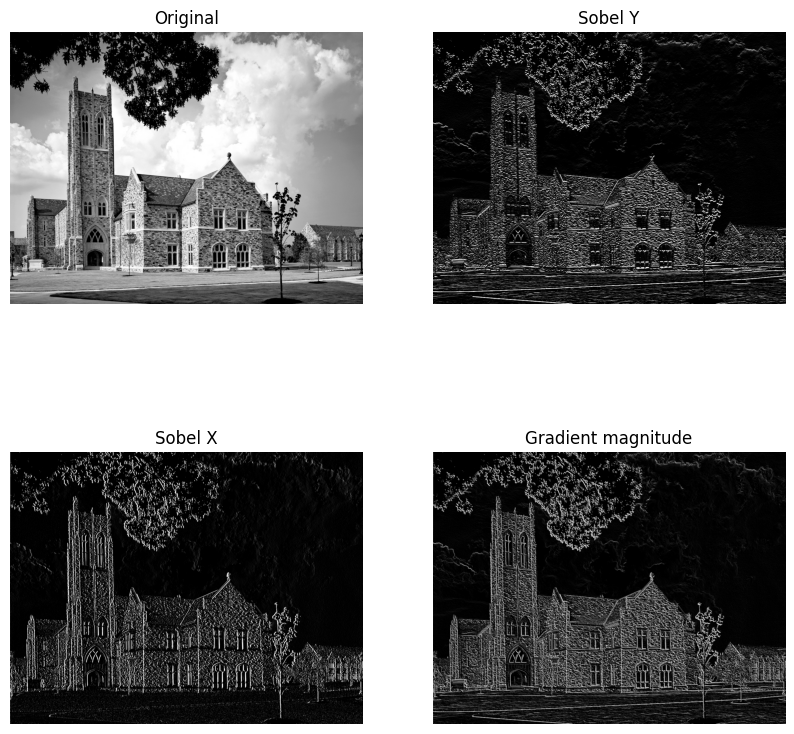

In [276]:
gradient_magnitude = sobel_operator('img/barrett.ppm')

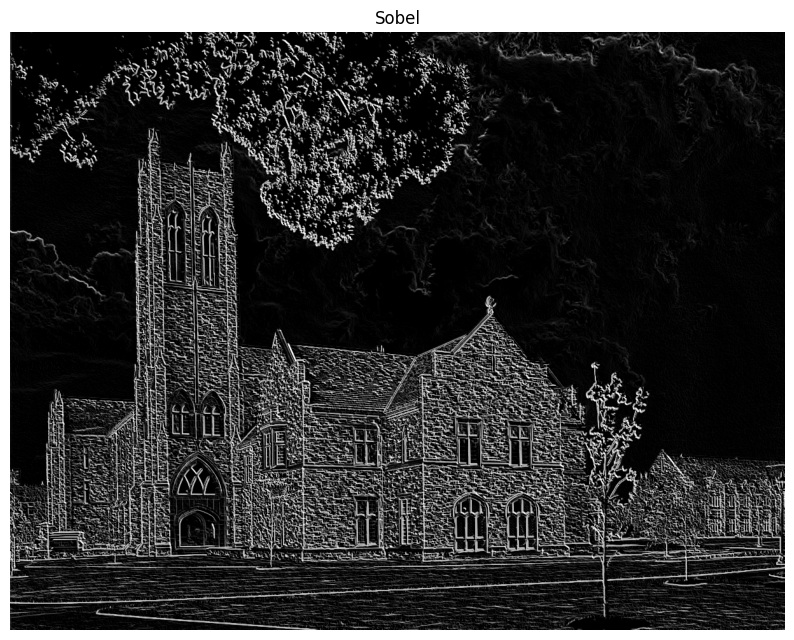

In [277]:
plt.figure(figsize=(10, 10))
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Sobel')

# Removendo os eixos
plt.axis('off')
plt.show()

#### 5. Um filtro passa-baixa bastante conhecido é o filtro Gaussiano. Através de uma máscara determinada por um desvio padrão σ, é possível fazer o que chamamos de suavização gaussiana de uma imagem. Considere o filtro 5x5 de desvio padrão unitário abaixo:
g = {{1/273, 4/273, 7/273, 4/273, 1/273}, {4/273, 16/273, 26/273, 16/273, 4/273}, {7/273, 26/273, 41/273, 26/273, 7/273}, {4/273, 16/273, 26/273, 16/273, 4/273}, {1/273, 4/273, 7/273, 4/273, 1/273}}
###Escolha uma imagem de sua referência e primeiro exiba as imagens resultantes obtidas após aplicar os resultados da questão 4 após aplicar somente o operador de Sobel; e após realizar uma filtragem com o filtro g seguida da aplicação do operador de Sobel.

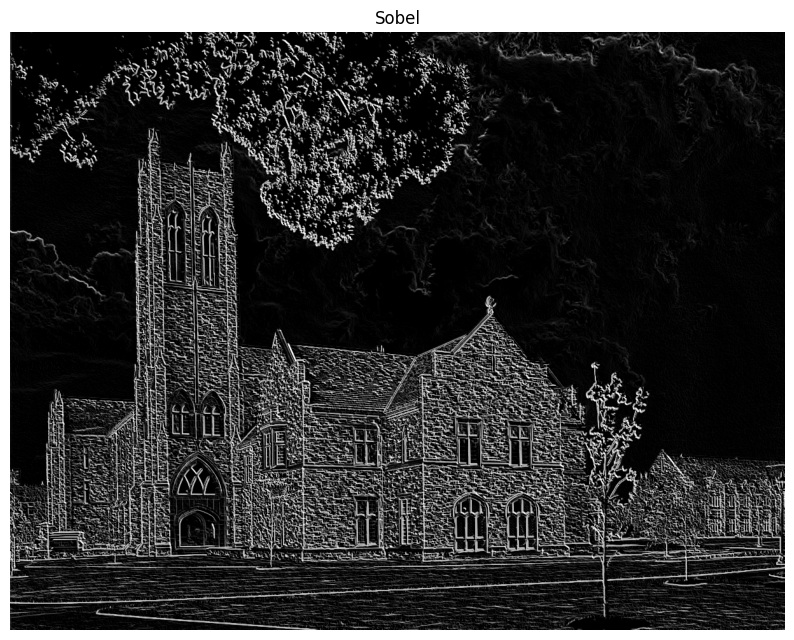

In [279]:
plt.figure(figsize=(10, 10))
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Sobel')

# Removendo os eixos
plt.axis('off')
plt.show()

In [ ]:
g = np.array([[1, 4, 7, 4, 1], 
               [4, 16, 26, 16, 4], 
               [7, 26, 41, 26, 7], 
               [4, 16, 26, 16, 4], 
               [1, 4, 7, 4, 1]])/273

passa_baixa = apply_convolution('img/new_york.ppm', 'output/5-new_york_gaussian.ppm', g)

0.0 255.0


C:\Users\ANCHIETA\AppData\Local\Temp\ipykernel_18948\1550017561.py:40: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  f.write(f"{int(pixel)} ")


0.0 255.0


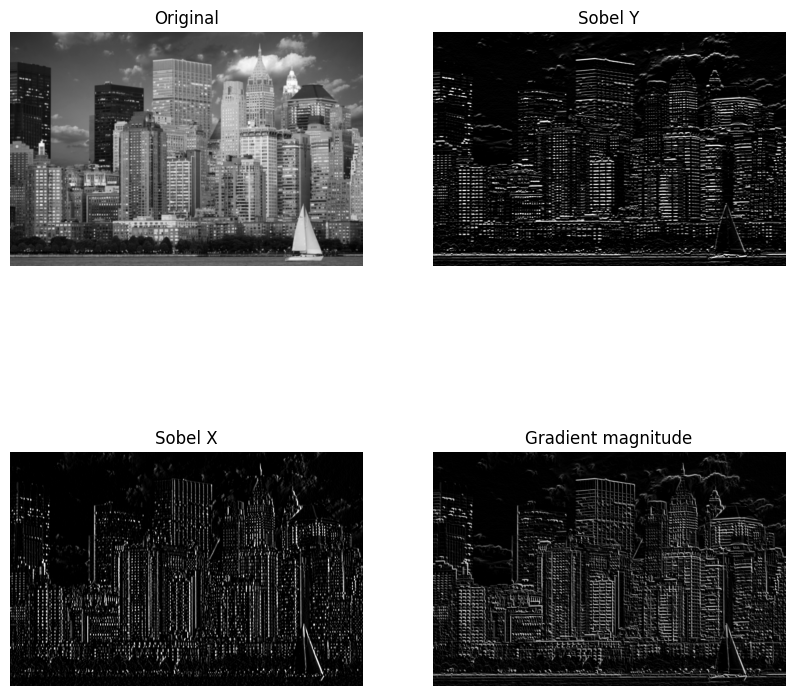

array([[[ 4.],
        [ 4.],
        [ 0.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 4.],
        [ 4.],
        [ 1.],
        ...,
        [ 0.],
        [ 0.],
        [ 0.]],

       [[ 4.],
        [ 4.],
        [ 3.],
        ...,
        [ 3.],
        [ 0.],
        [ 0.]],

       ...,

       [[10.],
        [ 5.],
        [ 2.],
        ...,
        [17.],
        [ 9.],
        [ 2.]],

       [[ 4.],
        [ 1.],
        [ 0.],
        ...,
        [17.],
        [15.],
        [ 6.]],

       [[ 7.],
        [ 6.],
        [ 0.],
        ...,
        [16.],
        [19.],
        [ 8.]]], shape=(639, 960, 1), dtype=float16)

In [278]:
sobel_operator('output/5-new_york_gaussian.ppm')

#### 6. Aplique o detector de canny usando a função Canny() da OpenCV em uma ou mais imagens de sua escolha. Experimente variar cada um dos parâmetros *threshold1*, *threshold2* e *apertureSize*. Explique com suas palavras a influência de cada parâmetro no resultado.

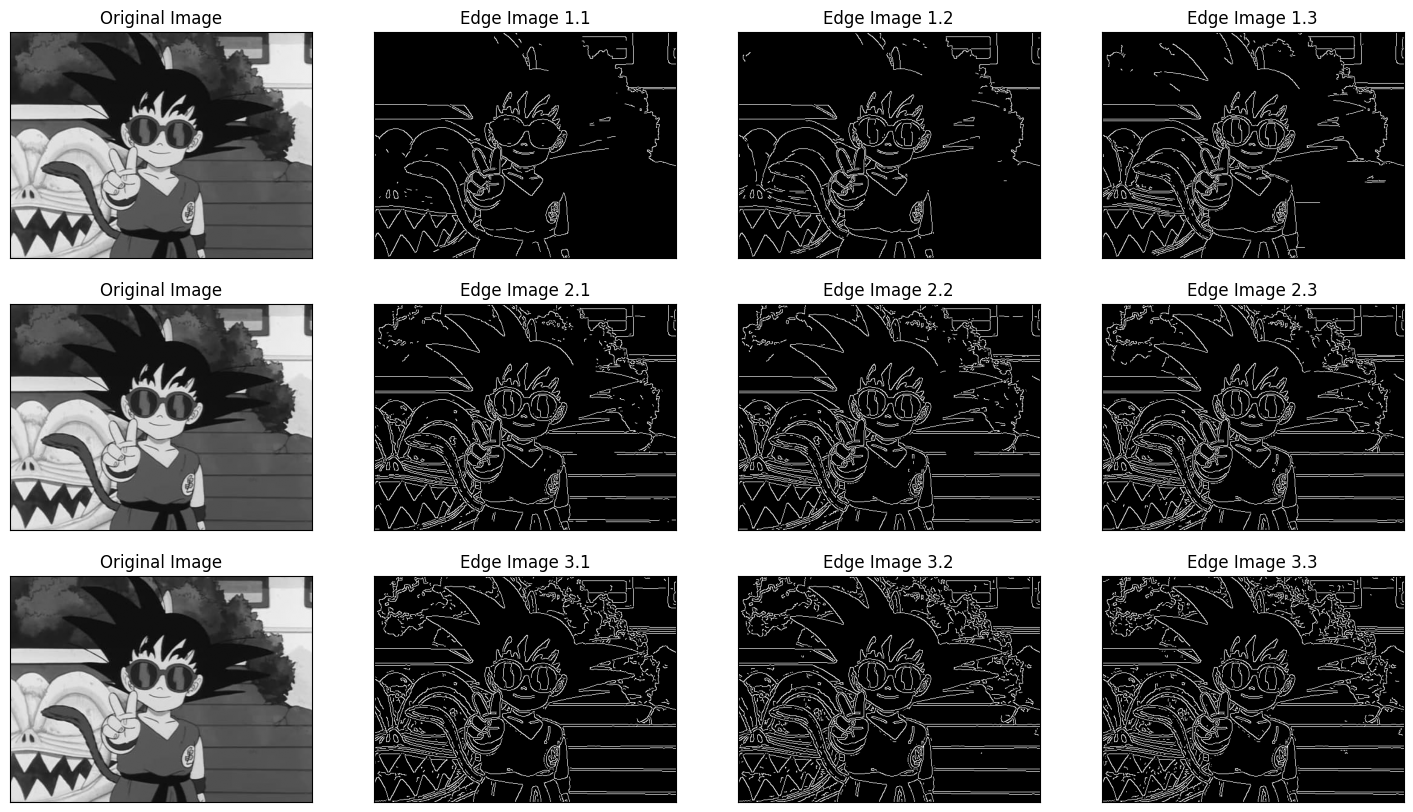

In [180]:
#Canny com threshold1 = 100; threshold2 = 200, apertureSize = 3
img = cv.imread('img\goku.jpg', cv.IMREAD_GRAYSCALE)
edges11 = cv.Canny(img, 200, 250, apertureSize= 3)
edges12 = cv.Canny(img, 150, 200, apertureSize= 3)
edges13 = cv.Canny(img, 100, 150, apertureSize= 3)
edges21 = cv.Canny(img, 900, 1000, apertureSize= 5)
edges22 = cv.Canny(img, 750, 900, apertureSize= 5)
edges23 = cv.Canny(img, 600, 750, apertureSize= 5)
edges31 = cv.Canny(img, 6000, 7500, apertureSize= 7)
edges32 = cv.Canny(img, 5000, 6000, apertureSize= 7)
edges33 = cv.Canny(img, 4500, 5000, apertureSize= 7)

plt.figure(figsize=(18,10))

plt.subplot(3,4,1),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(3,4,2),plt.imshow(edges11,cmap = 'gray')
plt.title('Edge Image 1.1'), plt.xticks([]), plt.yticks([])

plt.subplot(3,4,3),plt.imshow(edges12,cmap = 'gray')
plt.title('Edge Image 1.2'), plt.xticks([]), plt.yticks([])

plt.subplot(3,4,4),plt.imshow(edges13,cmap = 'gray')
plt.title('Edge Image 1.3'), plt.xticks([]), plt.yticks([])

plt.subplot(3,4,5),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(3,4,6),plt.imshow(edges21,cmap = 'gray')
plt.title('Edge Image 2.1'), plt.xticks([]), plt.yticks([])

plt.subplot(3,4,7),plt.imshow(edges22,cmap = 'gray')
plt.title('Edge Image 2.2'), plt.xticks([]), plt.yticks([])

plt.subplot(3,4,8),plt.imshow(edges23,cmap = 'gray')
plt.title('Edge Image 2.3'), plt.xticks([]), plt.yticks([])

plt.subplot(3,4,9),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(3,4,10),plt.imshow(edges31,cmap = 'gray')
plt.title('Edge Image 3.1'), plt.xticks([]), plt.yticks([])

plt.subplot(3,4,11),plt.imshow(edges32,cmap = 'gray')
plt.title('Edge Image 3.2'), plt.xticks([]), plt.yticks([])

plt.subplot(3,4,12),plt.imshow(edges33,cmap = 'gray')
plt.title('Edge Image 3.3'), plt.xticks([]), plt.yticks([])

plt.show()

Variar o threshrold 1 e 2 muda a quantidade de bordas que o cv.canny consegue capturar, de tal forma que o threshold 1 é o limite mínimo para que a borda seja capturada e o threshold 2 seria o limite máximo. Sendo assim, quanto menor for os valores dos threshold, melhor ele vai conseguir detectar as bordas mais suaves. Seguindo também por essa lógica, caso o threshold 1 e 2 sejam altos, serão incluídas bordas mais fortes, consequentemente, caso as variáveis sejam baixas, as bordas mais fracas serão incluídas.

Já o apertureSize é o tamanho do kernel que vai ser utilizado para calcular a variação de cores da imagem. Caso seja pequeno, a imagem terá menos detalhes, porém o tratamento de ruídos será melhor. Consequentemente se o apertureSize for alto, a imagem vai ter mais detalhes, porém mais suscetível a ter ruídos.

#### 7. Escolha uma imagem interessante e gere uma pirâmide aplicando sucessivamente downsampling 3 vezes com fator 1/2. Faça o mesmo com uma pirâmide gaussiana e compare os resultados. Mostre os resultados de cada pirâmide em uma única imagem lado a lado, como no slides 20 (vai exigir algumas operações de translação de imagens). Obs.: aqui você pode usar funções do OpenCV.

In [243]:
img_path = 'img\lebowski.jpg'
img = cv.imread(img_path)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

In [244]:
def create_gaussian_pyramid(img, levels = 3):
    layer = img.copy() 
    result = np.full((img.shape[0], img.shape[1] * 2, 3), 255, dtype=np.uint8)
    altura = 0

    plt.axis('off') 
    plt.title("gaussian pyramid")
    result[0:layer.shape[0], 0:layer.shape[1]] = layer
    for i in range(levels): 
        plt.axis('off') 

        layer = cv.pyrDown(layer) 
        
        result[altura:altura + layer.shape[0], img.shape[1]:img.shape[1] + layer.shape[1]] = layer

        # using pyrDown() function 
        altura += layer.shape[0]

    plt.imshow(result) 

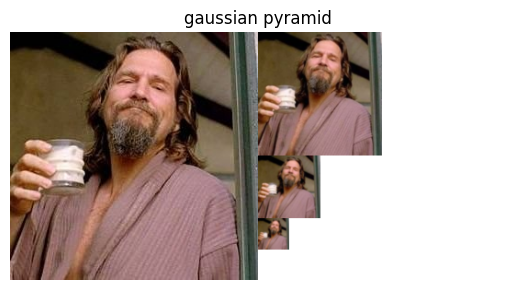

In [245]:
create_gaussian_pyramid(img, 3)

In [246]:
def create_downsample_pyramid(img, levels = 3):
    layer = img.copy() 
    result = np.full((img.shape[0], img.shape[1] * 2, 3), 255, dtype=np.uint8)
    altura = 0

    plt.axis('off') 
    plt.title("pyramid downsampling")
    result[0:layer.shape[0], 0:layer.shape[1]] = layer
    for i in range(levels): 
        plt.axis('off') 

        layer = cv.resize(layer, (layer.shape[0]//2, layer.shape[1]//2)) 
        
        result[altura:altura + layer.shape[0], img.shape[1]:img.shape[1] + layer.shape[1]] = layer

        # using pyrDown() function 
        altura += layer.shape[0]

    plt.imshow(result) 

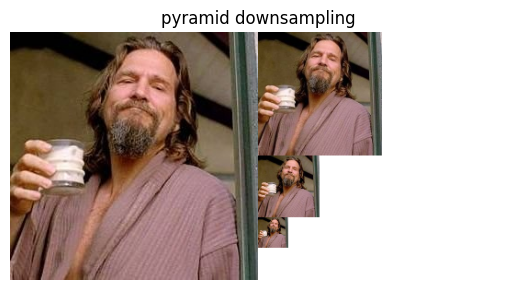

In [247]:
create_downsample_pyramid(img, 3)

A diferença é que a pirâmide gaussiana borra a imagem a cada nível antes de realizar o resize, já a downsampling vai apenas diminuir a imagem. Isso dá à pirâmide gaussiana uma aparência mais suave.

#### 8. Escolha uma imagem interessante e estude a função resize da OpenCV. Dobre as dimensões de sua imagem aplicando interpolação linear e bicúbica. Exiba os resultados e explique, em suas palavras, qual a diferença das imagens resultantes.

(93, 140, 3)


Text(0.5, 1.0, 'Original Image')

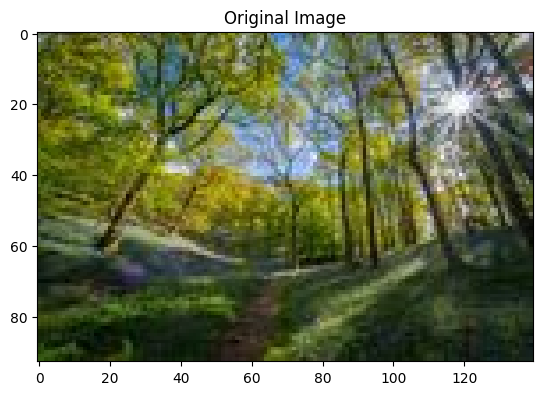

In [155]:
img = 'img/nature_smaller.jpeg'
img = mpimg.imread(img)

print(img.shape)

plt.imshow(img,cmap = 'viridis')
plt.title('Original Image')

In [156]:
img_linear = cv.resize(img, (img.shape[1] * 2, img.shape[0] * 2), interpolation=cv.INTER_LINEAR)

cv.imwrite('output/8-img2x_linear.jpg', cv.cvtColor(img_linear, cv.COLOR_RGB2BGR))

True

In [157]:
img_linear = cv.resize(img, (img.shape[1] * 5, img.shape[0] * 5), interpolation=cv.INTER_LINEAR)

cv.imwrite('output/8-img5x_linear.jpg', cv.cvtColor(img_linear, cv.COLOR_RGB2BGR))

True

In [158]:
img_cubic = cv.resize(img, (img.shape[1] * 2, img.shape[0] * 2), interpolation=cv.INTER_CUBIC)

cv.imwrite('output/8-img2x_cubic.jpg', cv.cvtColor(img_cubic, cv.COLOR_RGB2BGR))

True

In [159]:
img_cubic = cv.resize(img, (img.shape[1] * 5, img.shape[0] * 5), interpolation=cv.INTER_CUBIC)

cv.imwrite('output/8-img5x_cubic.jpg', cv.cvtColor(img_cubic, cv.COLOR_RGB2BGR))

True

Após realizar as interpolações, percebe-se que a interpolação linear dá um aspecto mais "borrado" da imagem, enquanto a interpolação bicúbica traz mais nitidez e detalhes à imagem. Quanto a resolução, é notório que a qualidade da imagem tem um aspecto de piora à medida que sua resolução é ampliada.

(Escolheu-se uma imagem com baixa resolução para que as diferenças ficassem mais notáveis)